# Fruit and Vegetable Classification
## \# Data
Taken from: https://www.kaggle.com/code/databeru/fruit-and-vegetable-classification

## \# Classes

Having 3861 images of 36 different fruits/vegetables

![fruit vegetable](https://i.imgur.com/KUAcIQD.jpeg)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/feature_detection.ipynb)

<h1>Table of contents</h1>


<ul>
<li><a href="#1"><strong>1. Loading and preprocessing</strong></a>
</ul>
    
<ul>
<li><a href="#2"><strong>2. Load the Images with a generator and Data Augmentation</strong></a>
</ul>

<ul>
<li><a href="#3"><strong>3. Train the model</strong></a>
</ul>

<ul>
<li><a href="#4"><strong>4. Visualize the result</strong></a>
</ul>

<ul>
<li><a href="#5"><strong>5. Class activation heatmap for image classification</strong></a>
</ul>

# Context

Image classification of fruits and vegetables has a wide range of applications in nutrition, cooking, farming, and produce wholesale. Being able to identify the type (fruit or vegetable) and class (which particular fruit or vegetable) is the foundational layer upon which one can build useful techniques related to produce such as quality evaluation, insect infestation, ripeness evaluation, sorting, recipe generation, and a myriad of others. Creating a well-performing baseline fruit and vegetable classifier opens up a world of possibilities for computer vision applications within the produce industry.

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

To balance the class distribution, we chose a subset of 10 of the 20 total vegetable classes. The following classes were analyzed as part of this project:

Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']



In [3]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog, daisy
from skimage.color import rgb2gray
from skimage import exposure
import matplotlib.pyplot as plt
# Load the Drive helper and mount
#from google.colab import drive

# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [4]:
import os

# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#mountdir = '/content/drive'
#drive.mount(mountdir, force_remount=True)

#localdir = mountdir + '/MyDrive'
# Replace your folder here
#w281_directory = '/Berkeley/w281/Fruit-and-Vegetable-Classification/'
#inputdir = localdir + w281_directory
# Uncomment below if using local folder

## Varun's Directory
inputdir = ""

## Michael Liston's Directory
#inputdir = "/Users/mcliston/Library/CloudStorage/GoogleDrive-michael.c.liston@gmail.com/My Drive/Berkeley/w281/Fruit-and-Vegetable-Classification/"

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import cv2
#import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path(inputdir, './input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(inputdir, './input/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(inputdir, './input/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# Filter only selected class

In [6]:
# Fruits - banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
# Vegetables - Bell Pepper, Cauliflower, Chilli Pepper, Peas, Corn, Spinach, Turnip, Garlic, Ginger, Cabbage
Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']

train_df = train_df[train_df['Label'].isin(Fruits + Vegetables)]
test_df = test_df[test_df['Label'].isin(Fruits + Vegetables)]
val_df = val_df[val_df['Label'].isin(Fruits + Vegetables)]

In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1540

Number of different labels: 20

Labels: ['turnip' 'corn' 'cauliflower' 'kiwi' 'pear' 'spinach' 'garlic' 'orange'
 'pomegranate' 'chilli pepper' 'bell pepper' 'apple' 'pineapple' 'banana'
 'cabbage' 'peas' 'grapes' 'mango' 'watermelon' 'ginger']


In [8]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
1,input/train/turnip/Image_17.jpg,turnip
2,input/train/corn/Image_38.jpg,corn
4,input/train/cauliflower/Image_71.jpg,cauliflower
6,input/train/kiwi/Image_34.jpg,kiwi
7,input/train/pear/Image_16.jpg,pear


# Show a sample of the image

turnip
(296, 296, 3)


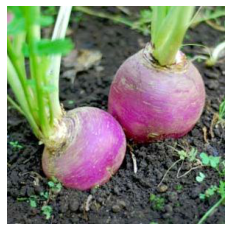

In [9]:
for index, row in train_df.iterrows():
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = imread(filepath)
  plt.axis("off")
  plt.imshow(img)
  print(label)
  print(img.shape)
  break

## Edge Detection

In [10]:
def find_edges(img):

  # converting to gray scale
  gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)

  # remove noise
  img = cv2.GaussianBlur(gray,(3,3),0)

  # convolve with proper kernels
  laplacian = cv2.Laplacian(img,cv2.CV_32F)
  sobelx = cv2.Sobel(img,cv2.CV_32F,1,0,ksize=5)  # x
  sobely = cv2.Sobel(img,cv2.CV_32F,0,1,ksize=5)  # y

  return laplacian, sobelx, sobely

def plot_edges(img, laplacian, sobelx, sobely):
  plt.axis("off")
  plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
  plt.title('Original'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
  plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
  plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
  plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

  plt.show()
  return

## Color Features

In [11]:
def get_color_features(im):

  img_512 = resize(img, (512, 512), anti_aliasing=True).astype(np.float32)
  hsv_image = cv2.cvtColor(img_512, cv2.COLOR_RGB2HSV)

  hue_channel = hsv_image[:, :, 0]
  saturation_channel = hsv_image[:, :, 1]
  value_channel = hsv_image[:, :, 2]

  # hue_mean = np.mean(hue_channel)
  # saturation_mean = np.mean(saturation_channel)
  # value_mean = np.mean(value_channel)

  # hue_std = np.std(hue_channel)
  # saturation_std = np.std(saturation_channel)
  # value_std = np.std(value_channel)

  return hue_channel, saturation_channel, value_channel

## Daisy Features

In [12]:
def compute_daisy_features(img):
    gray_img = rgb2gray(img) # must convert to grayscale when using skimage's daisy function
    descs, descs_img = daisy(gray_img, step=150, radius=40, rings=2, histograms=6, orientations=8, visualize=True)
    return descs_img, descs


9 DAISY descriptors extracted


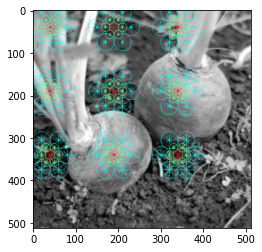

In [13]:
for index, row in train_df.iterrows():
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = imread(filepath)
  descs_img, descs = compute_daisy_features(resize(img, (512,512), anti_aliasing=True))
  descs_num = descs.shape[0] * descs.shape[1]
  print(f"{descs_num} DAISY descriptors extracted")
  plt.imshow(descs_img)
  break

## Scale-Invariant Feature Transform (SIFT)

In [14]:
def SIFT(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # convert to grayscale

    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptor = sift.detectAndCompute(gray_img, None)
    keypoints_without_size = np.copy(img)

    cv2.drawKeypoints(img, keypoints, keypoints_without_size, color = (0, 255, 0))

    return keypoints, keypoints_without_size

1305 Keypoints Detected


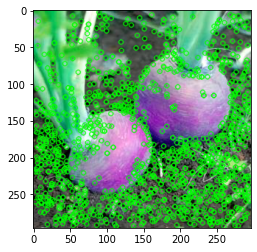

In [21]:
for index, row in train_df.iterrows():
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = cv2.imread(filepath)
  keypoints, keypoints_without_size = SIFT(img)
  descs_num = len(keypoints)
  print(f"{descs_num} Keypoints Detected")
  plt.imshow(keypoints_without_size, cmap='gray')
  break

## Generate Sample Images of Edges

## Constructing Feature Vectors

# PCA

In [ ]:
# Import required modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plotPCA(df, n_components=50, feature='Type of Feature'):
  pca = PCA(n_components=min(df.count(), n_components))

  # Perform fit
  converted_data = pca.fit(df.tolist())

  PC_values = np.arange(pca.n_components_) + 1
  plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
  plt.bar(PC_values, np.cumsum(pca.explained_variance_ratio_), color ='maroon',
          width = 0.4)
  plt.ylim(0.0,1.05)
  plt.legend([feature])
  plt.xlabel('Principal Component')
  plt.ylabel('Variance Explained')
  plt.show()

In [ ]:
img_dim = 512
pca_dim = 64 # Resize to 64 due to expensive calculation on PCA

train_df_features = pd.DataFrame(train_df,columns=['Filepath', 'Label', 'HOG', 'Hue', 'Saturation', 'Luminance', 'Laplacian', 'Sobel_X', 'Sobel_Y', 'Daisy'], dtype=object)

count = 0
# Set this lower to make it run faster, for example 10
num_examples = 100
for index, item in enumerate(train_df.iterrows()):
  if count >= num_examples:
    break
  count += 1
  row = item[1]
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = imread(filepath)

  resized_img = resize(img, (img_dim, img_dim), anti_aliasing=True)

  #creating hog features
  fd, hog_image = hog(resized_img, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(4, 4), visualize=True, channel_axis=-1)

  # creating edge features
  laplacian, sobelx, sobely = find_edges(resized_img)

  # creating color features
  hue_channel, saturation_channel, luminance_channel = get_color_features(resized_img)

  # creating daisy features
  daisy_img, descs = compute_daisy_features(resized_img)

  resized_hog_img = resize(hog_image, (pca_dim, pca_dim), anti_aliasing=True)
  resized_hue_img = resize(hue_channel, (pca_dim, pca_dim), anti_aliasing=True)
  resized_saturation_img = resize(saturation_channel, (pca_dim, pca_dim), anti_aliasing=True)
  resized_luminance_img = resize(luminance_channel, (pca_dim, pca_dim), anti_aliasing=True)
  resized_laplacian_img = resize(laplacian, (pca_dim, pca_dim), anti_aliasing=True)
  resized_sobelx_img = resize(sobelx, (pca_dim, pca_dim), anti_aliasing=True)
  resized_sobely_img = resize(sobely, (pca_dim, pca_dim), anti_aliasing=True)
  #resized_daisy_img = resize(daisy_img, (pca_dim, pca_dim), anti_aliasing=True)

  new_entry =  {'Filepath': filepath,
                'Label': label,
                'HOG': resized_hog_img.reshape(-1).astype(float),
                'Hue': resized_hue_img.reshape(-1).astype(float),
                'Saturation': resized_saturation_img.reshape(-1).astype(float),
                'Luminance': resized_luminance_img.reshape(-1).astype(float),
                'Laplacian': resized_laplacian_img.reshape(-1).astype(float),
                'Sobel_X': resized_sobelx_img.reshape(-1).astype(float),
                'Sobel_Y': resized_sobely_img.reshape(-1).astype(float),
                'Daisy': descs.reshape(-1).astype(float)}#resized_daisy_img.reshape(-1).astype(float)}

  train_df_features.loc[index] = new_entry

In [ ]:

train_df_features['HOG'] = train_df_features['HOG'].apply(lambda x: (x - np.mean(x)).astype(float))
train_df_features['Hue'] = train_df_features['Hue'] = train_df_features['Hue'].apply(lambda x: x - np.mean(x))
train_df_features['Saturation'] = train_df_features['Saturation'].apply(lambda x: x - np.mean(x))
train_df_features['Luminance'] = train_df_features['Luminance'].apply(lambda x: x - np.mean(x))
train_df_features['Laplacian'] = train_df_features['Laplacian'].apply(lambda x: x - np.mean(x))
train_df_features['Sobel_X'] = train_df_features['Sobel_X'].apply(lambda x: x - np.mean(x))
train_df_features['Sobel_Y'] = train_df_features['Sobel_Y'].apply(lambda x: x - np.mean(x))
train_df_features['Daisy'] = train_df_features['Daisy'].apply(lambda x: x - np.mean(x))


# HOG PCA

In [ ]:
hog_features = train_df_features.dropna(subset=['HOG'])

hog_features = hog_features['HOG']

# Plot PCA
plotPCA(hog_features, feature='HOG')

# Hue PCA

In [ ]:
hue_features = train_df_features.dropna(subset=['Hue'])

hue_features = hue_features['Hue']

# Plot PCA
plotPCA(hue_features, feature='Hue')

# Saturation PCA

In [ ]:
saturation_features = train_df_features.dropna(subset=['Saturation'])

saturation_features = saturation_features['Saturation']

# Plot PCA
plotPCA(saturation_features, feature='Saturation')

# Luminance PCA

In [ ]:
luminance_features = train_df_features.dropna(subset=['Luminance'])

luminance_features = luminance_features['Luminance']

# Plot PCA
plotPCA(luminance_features, feature='Luminance')

# Laplacian PCA

In [ ]:
laplacian_features = train_df_features.dropna(subset=['Laplacian'])

laplacian_features = laplacian_features['Laplacian']

# Plot PCA
plotPCA(laplacian_features, feature='Laplacian')

# Sobel X PCA

In [ ]:
sobelx_features = train_df_features.dropna(subset=['Sobel_X'])

sobelx_features = sobelx_features['Sobel_X']

# Plot PCA
plotPCA(sobelx_features, feature='Sobel_X')

# Sobel Y PCA

In [ ]:
sobely_features = train_df_features.dropna(subset=['Sobel_Y'])

sobely_features = sobely_features['Sobel_Y']

# Plot PCA
plotPCA(sobely_features, feature='Sobel_Y')

## Daisy Image PCA

In [ ]:
daisy_features = train_df_features.dropna(subset=['Daisy'])

daisy_features = daisy_features['Daisy']

# Plot PCA
plotPCA(daisy_features, feature='Daisy')

## Constructing Master DataFrame

In [ ]:
'''
img_dim = 512
train_df_features = pd.DataFrame(train_df,columns=['Filepath', 'Label', 'Raw', 'Resized','Laplacian','Sobel_X','Sobel_Y','Hue','Saturation','Luminance'], dtype=object)
#train_df_features.set_index('Filepath', inplace=True)
#print(train_df_features.head())
# adding a counter for debugging
ct = 0
for fp in train_df_features['Filepath']:
  if ct > 5: break
  ind = train_df_features[train_df_features['Filepath']==fp].index[0]
  img = imread(fp)

  train_df_features.at[ind,'Raw'] = img.astype(object)

  resized = resize(img, (img_dim, img_dim), anti_aliasing=True)
  train_df_features.at[ind,'Resized'] = resized

  # creating edge features
  laplacian, sobelx, sobely = find_edges(resized)

  train_df_features.at[ind,'Laplacian'] = laplacian
  train_df_features.at[ind,'Sobel_X'] = sobelx
  train_df_features.at[ind,'Sobel_Y'] = sobely

  # creating color features
  hue_channel, saturation_channel, luminance_channel = get_color_features(img)

  train_df_features.at[ind,'Hue'] = hue_channel
  train_df_features.at[ind,'Saturation'] = saturation_channel
  train_df_features.at[ind,'Luminance'] = luminance_channel

  ct += 1
print(train_df_features.head())
'''